<a href="https://colab.research.google.com/github/KatalinaE/Optimization-methods/blob/main/%D0%9A%D0%A0%E2%84%962.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание**: заниматься мы будем разделением сигналов, то есть решать задачу Blind Source Separation. Делать мы это будем, переформулируя задачу как задачу выпуклой оптимизации. Говоря простым языком, нам надо реализовать CAMNS method (convex  analysis  of  mixtures  of  non-negative sources), который решает задачу BSS при некоторых допущениях.

По сути мы хотим найти $W$ в уравнении: $$y = Wx,$$ где:
  * $y$ - выходной вектор,
  * $x$ - входной вектор смешанных сигналов, 
  * $W$ - невырожденная разделяющая матрица.

Таки займемся этим.

In [152]:
import cvxpy as cvx
import numpy as np

import time


def is_ext_pt(C, d, alpha, tol):
    _, D = C.shape
    T = C[np.all(np.abs(np.expand_dims(C.dot(alpha) + d, axis=1)) < tol, axis=1), :]
    ran = np.linalg.matrix_rank(T, tol=tol)
    return T.shape[0] != 0 or ran == D


def CAMNS_LP(X, N, TOL_LP=1e-3, TOL_EXT=1e-6, TOL_ZEROS=1e-6):
    start = time.time()
    _, L = X.shape
    X = X.T
    d = np.mean(X, axis=1)
    C, _, _ = np.linalg.svd(X - np.expand_dims(d, axis=1), full_matrices=False)
    C = C[:, :N-1]
    el = 0
    Q1 = np.diag(np.ones(L))
    hS = np.zeros((0, L))
    while el < N: 
        start_iter = time.time()
        w = np.random.normal(loc=0, scale=1, size=L)
        r = Q1.dot(w)
        
        alpha_1 = cvx.Variable(C.shape[1]) 
        p_star = cvx.Problem(cvx.Minimize(r.T @ (C @ alpha_1 + d)), [C @ alpha_1 + d >= 0]).solve(solver='ECOS_BB')
        alpha_2 = cvx.Variable(C.shape[1])
        q_star = cvx.Problem(cvx.Maximize(r.T @ (C @ alpha_2 + d)), [C @ alpha_2 + d >= 0]).solve(solver='ECOS_BB')

        if el == 0:
          if is_ext_pt(C, d, alpha_1.value, TOL_EXT):
            hS = np.append(hS, [(C @ alpha_1.value + d).squeeze()], axis=0)
          if is_ext_pt(C, d, alpha_2.value, TOL_EXT):
            hS = np.append(hS, [(C @ alpha_2.value + d).squeeze()], axis=0)
        else:
          if p_star / (np.linalg.norm(r) * np.linalg.norm(C @ alpha_1.value + d)) >= TOL_LP:
            if is_ext_pt(C, d, alpha_1.value, TOL_EXT):
              hS = np.append(hS, [(C @ alpha_1.value + d).squeeze()], axis=0)
          if q_star / (np.linalg.norm(r) * np.linalg.norm(C @ alpha_1.value + d)) >= TOL_LP:
            if is_ext_pt(C, d, alpha_2.value, TOL_EXT):
              hS = np.append(hS, [(C @ alpha_2.value + d).squeeze()], axis=0)

        el = hS.shape[0]

        if el > 0:
          Q, _ = np.linalg.qr(hS.T)
          Q1 = np.diag(np.ones(L)) - Q @ Q.T
          
        print('Iter time - {}s'.format(time.time() - start_iter))
        
    print('Algorithm time - {}s'.format(time.time() - start))
    return hS

Для загрузки и лицезрения котиков напишем вспомогательные функции:

In [153]:
import matplotlib.pyplot as plt


def load_image(path):
    src = plt.imread(path)
    # Only green
    src = np.delete(src, (0, 2), axis=2)
    return src.reshape(128 * 128).astype(np.float64) / 255.0


def load_images(paths):
    return [load_image(path) for path in paths]


def show_images(images):    
    count = len(images)
    fig, ax = plt.subplots(1, count, figsize=(4 * count, 4))
    
    for i, image in enumerate(images):
        ax[i].imshow(image.reshape(128, 128), cmap=plt.cm.gray)

Загружаем наших красивых черных котиков и делаем их черно-белыми.

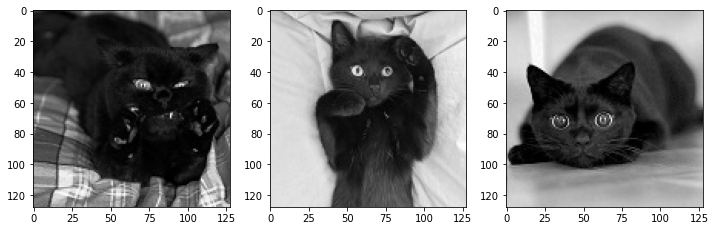

In [154]:
paths = [
    'images/1.jpg',
    'images/2.jpg',
    'images/3.jpg'
]

images = load_images(paths)
show_images(images)

Теперь перемешаем наших котиков.

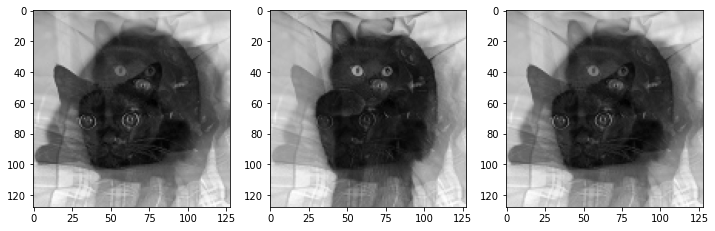

In [155]:
N = len(images)
A = np.random.rand(N, N)
MIX = A / np.sum(A, axis=1, keepdims=True)
X = MIX.dot(images)

show_images(X)

А теперь восстановим обратно, чтобы еще раз ими насладиться. 

Iter time - 4.545178651809692s
Iter time - 5.0439293384552s
Iter time - 4.9483795166015625s
Iter time - 4.952790975570679s
Iter time - 4.945407390594482s
Algorithm time - 24.953431606292725s


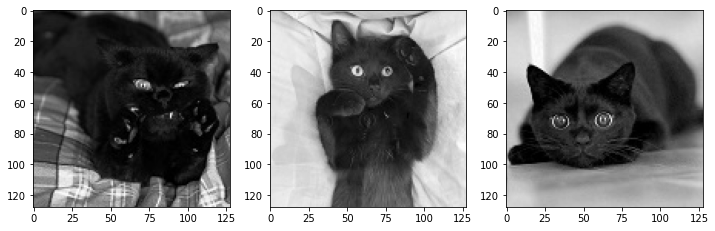

In [156]:
hS = CAMNS_LP(X, N)
show_images(hS)

Уииииииииииииииии, котики (а какой котик Вы сегодня? =^.^=)